### Denoise images using the Marcenko-Pastur PCA algorithm

The PCA-based denoising algorithm exploits the redundancy across the diffusion-weighted images [Manjon2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073021), [Veraart2016a](https://pubmed.ncbi.nlm.nih.gov/27523449/). This algorithm has been shown to provide an optimal compromise between noise suppression and loss of anatomical information for different techniques such as DTI [Manjon2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073021), spherical deconvolution [Veraart2016a](https://pubmed.ncbi.nlm.nih.gov/27523449/) and DKI [NetoHe2018](https://www.repository.cam.ac.uk/handle/1810/281993).

In the following example, we show how to denoise diffusion MRI images and estimate the noise standard deviation using the PCA algorithm based on the Marcenko-Pastur distribution [Veraa2016a](https://pubmed.ncbi.nlm.nih.gov/27523449/).

Let’s load the necessary modules:

In [1]:
# load general modules
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from time import time

# load functions to fetch data for this example
from dipy.data import get_fnames
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

# load other dipy's functions that will be used for auxiliar analysis
from dipy.segment.mask import median_otsu

For this example, we use fetch to download a multi-shell dataset which was kindly provided by Hansen and Jespersen (more details about the data are provided in their paper [Hansen2016]).

In [2]:
dwi_fname, dwi_bval_fname, dwi_bvec_fname, _ = get_fnames('cfin_multib')
data, affine = load_nifti(dwi_fname)
bvals, bvecs = read_bvals_bvecs(dwi_bval_fname, dwi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

For the sake of simplicity, we only select two non-zero b-values for this example.

In [3]:
bvals = gtab.bvals

bvecs = gtab.bvecs

sel_b = np.logical_or(np.logical_or(bvals == 0, bvals == 1000), bvals == 2000)

data = data[..., sel_b]

gtab = gradient_table(bvals[sel_b], bvecs[sel_b])

print(data.shape)

(96, 96, 19, 67)


As one can see from its shape, the selected data contains a total of 67 volumes of images corresponding to all the diffusion gradient directions of the selected b-values.

The PCA denoising using the Marcenko-Pastur distribution can be performed by calling the function "mppca" from "dipy.denoise.localpca" (this can take some time to run)

In [4]:
from dipy.denoise.localpca import mppca

denoised_arr = mppca(data, patch_radius=2)

Internally, the mppca algorithm denoises the diffusion-weighted data using a 3D sliding window which is defined by the variable patch_radius. In total, this window should comprise a larger number of voxels than the number of diffusion-weighted volumes. Since our data has a total of 67 volumes, the patch_radius is set to 2 which corresponds to a 5x5x5 sliding window comprising a total of 125 voxels.

To assess the performance of the Marcenko-Pastur PCA denosing algorithm, an axial slice of the original data, denoised data, and residuals are plotted below:

The result saved in denoised_mppca.png


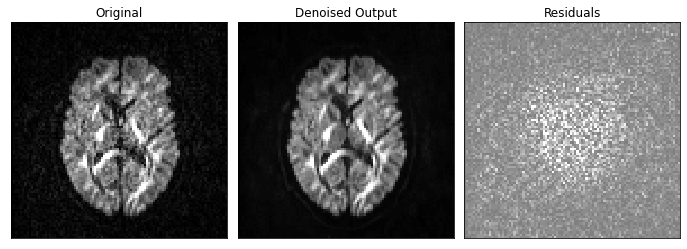

In [5]:
sli = data.shape[2] // 2
gra = data.shape[3] - 1
orig = data[:, :, sli, gra]
den = denoised_arr[:, :, sli, gra]
rms_diff = np.sqrt((orig - den) ** 2)

fig1, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower',  vmin=0, vmax=80)
ax.flat[0].set_title('Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower', vmin=0, vmax=80)
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower', vmin=-10, vmax=10)
ax.flat[2].set_title('Residuals')

fig1.savefig('denoised_mppca.png')

print("The result saved in denoised_mppca.png")

The noise suppressing can be visually appreciated by comparing the original data slice (left panel) to its denoised version (middle panel). The difference between original and denoised data showing only random noise indicates that the data’s structural information is preserved by the PCA denoising algorithm (right panel).

### Exercise
In this exercise let's see how the PCA denoising algorithm affects different diffusion measurements. For this, run the diffusion diffusion kurtosis model below on both original and denoised versions of the data and plot the MD, FA and MK estimates from the two data fits.

In [14]:
import dipy.reconst.dki as dki
dkimodel = dki.DiffusionKurtosisModel(gtab)

maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

# insert your code below

### Noise standard deviation estimation using the Marcenko-Pastur PCA algorithm

the Marcenko-Pastur PCA algorithm can also be used to estimate the image’s noise standard deviation (std). The noise std automatically computed from the mppca function can be returned by setting the optional input parameter return_sigma to True.

In [10]:
denoised_arr, sigma = mppca(data, patch_radius=2, return_sigma=True)

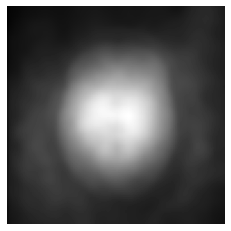

In [11]:
fig3 = plt.figure('PCA Noise standard deviation estimation')
plt.imshow(sigma[..., sli].T, cmap='gray', origin='lower')
plt.axis('off')
plt.show()

The above figure shows that the Marcenko-Pastur PCA algorithm computes a 3D spatial varying noise level map. To obtain the mean noise std across all voxels, you can use the following lines of code:

In [12]:
mean_sigma = np.mean(sigma[mask])

Below we use this mean noise level estimate to compute the data’s nominal SNR (i.e. SNR at b-value=0):

In [13]:
b0 = denoised_arr[..., 0]

mean_signal = np.mean(b0[mask])

snr = mean_signal / mean_sigma

print(snr)

34.56180377412377
